### **0. 前準備（必要パッケージのインストール・ライブラリの導入）**


In [ ]:
# パッケージをインストール
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install ipywidgets
!pip install notebook

In [1]:
import cv2
import random

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# 動的にパラメータを調整するためのライブラリ
import ipywidgets as widgets
from ipywidgets import interact

### **1. 線を引く場合**

**以下のプログラムでは，赤いマーカーを使用した例を使用している．実際色としては，土台とスポンジの色と被らなければなんでもいいが，他の色の場合はパラメータは別途調整する必要がある．また，赤線の距離が近すぎて，どうしても望ましくない箇所につながってしまう場合は，青または緑のマーカで使い分けてください．さらに，赤線についてはマーカーを用いず，撮影した画像をiPadに送って，iPadで線を引いたほうが修正しやすいと同時に，色の識別もしやすいため比較的にいいと思います。**

**実験の流れ：**
1. **[a-1, a-2]** まず，撮影した画像をパソコンに転送して，パソコンでクロップまたは座標変換する．その後，画像サイズを(224x224) に調整する．今回は画像のクロップと座標変換を両方実装したが，座標変換のほうが明らかに精度がいいためこちらの方を使用することをおすすめする．
1. **[b]** つぎに，使用したマーカの色を認識するために，閾値の調整を行う．原始的な手法であるが，画像を拡大して，マーカーのところをできるだけ細かく表示してから，ピクセル値を観察しながらパラメータを調整する．
1. **[c]** 最後に，いくつかのパラメータを設定して，作成した残りのプログラムを実行したらいけるはず．

#### a-1. 画像をクロップする場合（非推奨）

In [12]:
"""
1. 画像をクロップする場合
"""

# Load the image
image = cv2.cvtColor(cv2.imread("/home/tsy/Documents/ComputerVision/ImageProcessing/WestLand/board2+object+lines.jpeg"), cv2.COLOR_BGR2RGB)

# Function to crop the image
def crop_interact(crop_down, crop_up, crop_left, crop_right, Ox, Oy):

    # Ensure the crop boundaries are valid
    print(f"{crop_down}, {crop_up}, {crop_left}, {crop_right}, {Ox}, {Oy}\n")
    cropped_image = image[crop_up:crop_down, crop_left:crop_right]
    # resized_image = cv2.resize(cropped_image, (224, 224))
    cv2.circle(cropped_image, center=(Ox, Oy), radius=3, color=(0, 0, 255), thickness=-1)

    # Display the cropped image
    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_image, cmap='gray')


# Create interactive sliders for cropping parameters
interact(
    crop_interact,
    crop_up=widgets.IntSlider(min=0, max=image.shape[0] - 1, step=1, value=133, description='Crop Up'),
    crop_down=widgets.IntSlider(min=1, max=image.shape[0], step=1, value=780, description='Crop Down'),
    crop_left=widgets.IntSlider(min=0, max=image.shape[1] - 1, step=1, value=230, description='Crop Left'),
    crop_right=widgets.IntSlider(min=1, max=image.shape[1], step=1, value=810, description='Crop Right'),
    Ox=widgets.IntSlider(min=115, max=120, step=1, value=112, description='Ox'),
    Oy=widgets.IntSlider(min=115, max=120, step=1, value=112, description='Oy'),
)

interactive(children=(IntSlider(value=780, description='Crop Down', max=818, min=1), IntSlider(value=133, desc…

<function __main__.crop_interact(crop_down, crop_up, crop_left, crop_right, Ox, Oy)>

#### a-2. 画像を座標変換する場合

In [ ]:
"""
2. 画像を座標変換する場合
"""

# Load the image
image = cv2.cvtColor(cv2.imread("/home/tsy/Documents/ComputerVision/ImageProcessing/WestLand/images/board2_object_lines.png"), cv2.COLOR_BGR2RGB)
dst_points = [(0, 0), (224, 0), (0, 224), (224, 224)]

def warp_image(image, src_points, dst_points):
    """
    画像の4点を指定して座標変換を行い、新しい画像を生成するプログラム。

    Parameters:
    - input_image_path: 入力画像のパス
    - output_image_path: 出力画像のパス
    - src_points: 元の画像上の4点 [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    - dst_points: 出力画像上の4点 [(x1', y1'), (x2', y2'), (x3', y3'), (x4', y4')]
    """

    # 4点の座標をnumpy配列に変換
    src = np.array(src_points, dtype=np.float32)
    dst = np.array(dst_points, dtype=np.float32)

    # 射影変換行列を計算
    matrix = cv2.getPerspectiveTransform(src, dst)

    # 出力画像のサイズを指定
    # ここでは出力画像の幅と高さを、変換先の4点を元に計算します
    width = int(max(dst[:, 0]) - min(dst[:, 0]))
    height = int(max(dst[:, 1]) - min(dst[:, 1]))

    # 射影変換を適用
    warped_image = cv2.warpPerspective(image, matrix, (width, height))

    return warped_image


def warp_interact(x1, y1, x2, y2, x3, y3, x4, y4):
    warped_image = warp_image(image, [(x1, y1), (x2, y2), (x3, y3), (x4, y4)], dst_points)
    print(f"[({x1}, {y1}), ({x2}, {y2}), ({x3}, {y3}), ({x4}, {y4})]\n")

    # 画像を表示
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.scatter([x1, x2, x3, x4], [y1, y2, y3, y4], color='red')
    plt.subplot(1, 2, 2)
    plt.imshow(warped_image)
    plt.title("Warped Image")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


# インタラクティブUI
interact(
    warp_interact,
    x1=widgets.IntSlider(min=0, max=image.shape[1], step=2, value=222), 
    y1=widgets.IntSlider(min=0, max=image.shape[0], step=2, value=744),
    x2=widgets.IntSlider(min=0, max=image.shape[1], step=2, value=245),
    y2=widgets.IntSlider(min=0, max=image.shape[0], step=2, value=126),
    x3=widgets.IntSlider(min=0, max=image.shape[1], step=2, value=810),
    y3=widgets.IntSlider(min=0, max=image.shape[0], step=2, value=760),
    x4=widgets.IntSlider(min=0, max=image.shape[1], step=2, value=808),
    y4=widgets.IntSlider(min=0, max=image.shape[0], step=2, value=138),
)

interactive(children=(IntSlider(value=222, description='x1', max=1001, step=2), IntSlider(value=744, descripti…

<function __main__.warp_interact(x1, y1, x2, y2, x3, y3, x4, y4)>

#### b. 色の閾値のパラメータを調整

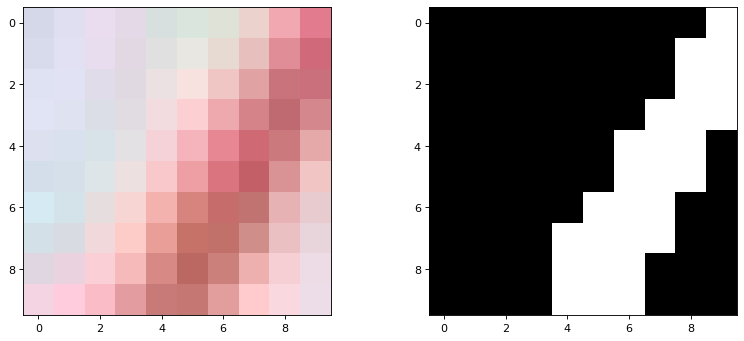


=================== RED ====================
[[213 224 234 228 215 218 223 235 241 226]
 [216 226 232 226 224 232 231 231 224 208]
 [223 225 224 224 235 247 239 224 201 202]
 [225 223 219 225 242 252 238 213 191 212]
 [221 217 216 227 245 245 231 207 203 229]
 [212 214 221 236 249 238 218 195 217 241]
 [214 212 230 247 243 215 198 193 230 232]
 [211 216 241 253 233 198 193 207 234 232]
 [224 234 250 246 215 187 203 237 246 237]
 [244 255 250 227 200 197 226 255 249 237]]
================== GREEN ===================
[[216 223 221 217 224 229 226 210 168 123]
 [219 225 221 216 224 231 218 191 141 105]
 [226 226 220 217 225 226 198 162 115 112]
 [228 226 222 220 220 207 169 131 106 135]
 [224 225 227 225 210 180 135 105 121 169]
 [222 224 229 224 200 159 116  95 147 197]
 [234 227 221 213 178 132 108 115 178 203]
 [224 219 216 204 158 114 113 142 192 213]
 [214 210 207 186 137 104 128 176 207 220]
 [212 204 188 156 122 119 158 203 216 221]]
================== BLUE ====================
[[

In [8]:
# Crop the image
# DOWN, UP, LEFT, RIGHT, Ox, Oy = 515, 505, 700, 710, 115, 115   # board2+object+line
DOWN, UP, LEFT, RIGHT, Ox, Oy = 580, 570, 400, 410, 115, 115   # board2+object+lines

# 画像の読み込み
image_path = '/home/tsy/Documents/ComputerVision/ImageProcessing/WestLand/images/board2_object_lines.png'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

cropped_image = image[UP:DOWN, LEFT:RIGHT]
cv2.circle(cropped_image, center=(Ox, Oy), radius=2, color=(0, 0, 0), thickness=-1)

plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(121)
plt.imshow(cropped_image)
plt.subplot(122)
mask = (cropped_image[:,:,0] > 180) * (cropped_image[:,:,1] < 160) * (cropped_image[:,:,2] < 160)
plt.imshow(mask, cmap='gray')
plt.show()

print(f"")
print(f"=================== RED ====================")
print(cropped_image[:,:,0])
print(f"================== GREEN ===================")
print(cropped_image[:,:,1])
print(f"================== BLUE ====================")
print(cropped_image[:,:,2])


#### c. スポンジ間の線を生成

In [ ]:
class ConnectPoints(object):

    def __init__(self, image_path, image_size=(224, 224), origin=(112, 112)):
        self.image_path = image_path
        self.image      = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        self.image_size = image_size
        self.origin     = origin
        self.mask       = None

        self.target_indices = None

    def reset_image(self):
        self.image = cv2.cvtColor(cv2.imread(self.image_path), cv2.COLOR_BGR2RGB)

    def warp_image(self, src_points, dst_points):
        """
        画像の4点を指定して座標変換を行い、新しい画像を生成するプログラム。

        Parameters:
        - input_image_path: 入力画像のパス
        - output_image_path: 出力画像のパス
        - src_points: 元の画像上の4点 [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
        - dst_points: 出力画像上の4点 [(x1', y1'), (x2', y2'), (x3', y3'), (x4', y4')]
        """

        # 4点の座標をnumpy配列に変換
        src = np.array(src_points, dtype=np.float32)
        dst = np.array(dst_points, dtype=np.float32)

        # 射影変換行列を計算
        matrix = cv2.getPerspectiveTransform(src, dst)

        # 出力画像のサイズを指定
        # ここでは出力画像の幅と高さを、変換先の4点を元に計算します
        width = int(max(dst[:, 0]) - min(dst[:, 0]))
        height = int(max(dst[:, 1]) - min(dst[:, 1]))

        # 射影変換を適用
        self.image = cv2.warpPerspective(self.image, matrix, (width, height))


    def crop_image(self, crop_down, crop_up, crop_left, crop_right, display_or_not=True):
        # Ensure the crop boundaries are valid
        cropped_image = self.image[crop_up:crop_down, crop_left:crop_right]
        cropped_image = cv2.resize(cropped_image, self.image_size)

        if display_or_not:
            # Display the cropped image
            cv2.circle(cropped_image, center=self.origin, radius=3, color=(0, 0, 255), thickness=-1)
            plt.figure(figsize=(6, 6))
            plt.imshow(cropped_image, cmap='gray')
            plt.axis('off')
            plt.show()

        self.image = cropped_image


    def create_mask(self, red_th, green_th, blue_th, color="red", display_or_not=True):

        if color == "red":
            self.mask = (self.image[:,:,0] > red_th) * (self.image[:,:,1] < green_th) * (self.image[:,:,2] < blue_th)
        if color == "green":
            self.mask = (self.image[:,:,0] < red_th) * (self.image[:,:,1] > green_th) * (self.image[:,:,2] < blue_th)
        if color == "blue":
            self.mask = (self.image[:,:,0] < red_th) * (self.image[:,:,1] < green_th) * (self.image[:,:,2] > blue_th)

        cv2.circle(self.image, center=self.origin, radius=2, color=(0, 0, 0), thickness=-1)
        self.target_indices = np.where(self.mask == 1)

        if display_or_not:
            plt.figure(figsize=(12, 5), dpi=80)
            plt.subplot(121)
            plt.imshow(self.image, cmap='gray')
            plt.xticks(np.arange(0, self.image_size[0], 20), np.arange(-self.origin[0], self.image_size[0]-self.origin[0], 20))
            plt.yticks(np.arange(0, self.image_size[0], 20), np.arange(-self.origin[1], self.image_size[0]-self.origin[1], 20))
            plt.xlabel("y")
            plt.ylabel("x")

            plt.subplot(122)
            plt.imshow(self.mask, cmap='gray')
            plt.xticks(np.arange(0, self.image_size[0], 20), np.arange(-self.origin[0], self.image_size[0]-self.origin[0], 20))
            plt.yticks(np.arange(0, self.image_size[0], 20), np.arange(-self.origin[1], self.image_size[0]-self.origin[1], 20))
            plt.xlabel("y")
            plt.ylabel("x")
            plt.grid(True)
            plt.show()

    def get_slope_intercept(self, point1, point2):
        """
        Calculate the slope (k) and intercept (b) of a line given two points.

        Args:
        - point1: Tuple (x1, y1), first point.
        - point2: Tuple (x2, y2), second point.

        Returns:
        - k: Slope of the line.
        - b: Intercept of the line.
        """
        x1, y1 = point1
        x2, y2 = point2

        # Check for vertical line (undefined slope)
        if x2 == x1:
            return float('inf'), x1  # Vertical line: slope is infinite, intercept is x

        # Calculate slope (k) and intercept (b)
        k = (y2 - y1) / (x2 - x1)
        b = y1 - k * x1
        return [k, b]

    def points_clustering(self, line_num=2, random_state=3, display_or_not=True):

        # Data
        x = self.target_indices[0]
        y = self.target_indices[1]

        # Combine x and y into a 2D array
        points = np.column_stack((x, y))

        # Step 1: Cluster points into two groups using KMeans
        kmeans = KMeans(n_clusters=line_num, random_state=random_state).fit(points)
        labels = kmeans.labels_  # Cluster labels for each point

        # Step 2: Separate points by cluster and fit a line to each cluster
        clusters= [points[labels == i] for i in range(line_num)]

        # Fit line to clusters
        lines, kandb = [], []
        for i, cluster in enumerate(clusters):
            reg = LinearRegression().fit(cluster[:, 0].reshape(-1, 1), cluster[:, 1])
            line_y = np.linspace(min(cluster[:, 0]), max(cluster[:, 0]), 100)
            line_x = reg.predict(line_y.reshape(-1, 1))
            lines.append([line_x, line_y])
            kandb.append(self.get_slope_intercept((min(cluster[:, 0]), min(cluster[:, 1])), (max(cluster[:, 0]), max(cluster[:, 1]))))


        if display_or_not:
            # Step 3: Visualization
            plt.figure(figsize=(6, 6), dpi=100)
            plt.scatter(x, y, c=labels, cmap='viridis', label="Data Points")  # Color-coded clusters

            for i, (line_x, line_y) in enumerate(lines):
                plt.plot(line_y, line_x, label=f"Line {i}")

            plt.xlabel("X")
            plt.ylabel("Y")
            plt.legend()
            plt.title("Clustering Points into Two Lines")
            plt.show()

        return np.array(lines), np.array(kandb)


    def draw_lines(self, pcd1, pcd2, color, sample_num=25, random_seed=0, display_or_not=False):
        """
        Draws lines connecting corresponding points from two point clouds (pcd1 and pcd2) on the same plot.

        Parameters:
            pcd1: List of points in the first point cloud (e.g., [(x1, y1), (x2, y2), ...])
            pcd2: List of points in the second point cloud (e.g., [(x1, y1), (x2, y2), ...])
            color: Color of the lines to be drawn.
        """
        random.seed(random_seed)
        np.random.seed(random_seed)

        if sample_num:
            pcd1 = random.sample(pcd1, sample_num)
            pcd2 = random.sample(pcd2, sample_num)

        # Iterate through both point clouds and connect corresponding points
        for point1, point2 in zip(pcd1, pcd2):
            x1, y1 = point1
            x2, y2 = point2

            if display_or_not:
                plt.plot([x1, x2], [y1, y2], color=color, lw=1, markersize=4)

        return pcd1, pcd2


    def connect_two_lines(self, line1, line2, color='green', sample_num=25, random_seed=0, display_or_not=True):

        line1_pts = [(x, y) for x, y in zip(line1[0], line1[1])]
        line2_pts = [(x, y) for x, y in zip(line2[0], line2[1])]

        sampled_pcd1, sampled_pcd2 = self.draw_lines(line1_pts, line2_pts, color, sample_num, random_seed, display_or_not)
        pcd1_x = np.array([xy[0] for xy in sampled_pcd1])
        pcd1_y = np.array([xy[1] for xy in sampled_pcd1])
        pcd1   = np.array([pcd1_x, pcd1_y])

        pcd2_x = np.array([xy[0] for xy in sampled_pcd2])
        pcd2_y = np.array([xy[1] for xy in sampled_pcd2])
        pcd2   = np.array([pcd2_x, pcd2_y])

        if display_or_not:
            plt.imshow(self.image)

            plt.plot(line1[0], line1[1], color='purple', label="Line 1")
            plt.plot(line2[0], line2[1], color='blue', label="Line 2")

            plt.xticks(np.arange(0, self.image_size[0], 20), np.arange(-self.origin[0], self.image_size[0]-self.origin[0], 20))
            plt.yticks(np.arange(0, self.image_size[0], 20), np.arange(-self.origin[1], self.image_size[0]-self.origin[1], 20))
            plt.xlabel("y")
            plt.ylabel("x")

        return pcd1, pcd2


    def get_distance_k_b(self, p1, p2, k1, k2):
        """
        Calculate the distance and angle between two lines and pair them accordingly.
        Returns the angle in degrees and the distance.
        """
        distance = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
        angle = np.arctan(abs((k2 - k1) / (1 + k1 * k2)))

        # Convert angle to degrees for better understanding
        angle_degrees = np.degrees(angle)

        return distance, angle_degrees


    def get_measure(self, p1, p2):
        distance = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
        
        return distance


    def pair_lines(self, lines, kandb):

        line_pairs = []
        line_indices  = range(len(lines))
        for line, kandb, line_idx in zip(lines, kandb, line_indices):
            line_pairs.append((line, kandb, line_idx))

        line_pairs = list(combinations(line_pairs, 2))

        # Initialize an empty matrix to store the measures
        num_lines = len(lines)
        measure_matrix = np.zeros((num_lines, num_lines))

        # Calculate the pairwise measure for each line pair
        for i, ((line1, [k1, b1], line1_index), (line2, [k2, b2], line2_index)) in enumerate(line_pairs):
            point1 = (np.mean(line1[0]), np.mean(line1[1]))
            point2 = (np.mean(line2[0]), np.mean(line2[1]))
            measure = self.get_measure(point1, point2)
            
            # Fill in the measure matrix (symmetrically)
            measure_matrix[line1_index, line2_index] = measure
            measure_matrix[line2_index, line1_index] = measure

        np.fill_diagonal(measure_matrix, np.inf)  # Ignore diagonal elements (self-pairing)

        pairs = []  # To store the pairs of indices
        while np.min(measure_matrix) != np.inf:  # While there are valid minimum values
            # Find the index of the minimum value
            min_index = np.unravel_index(np.argmin(measure_matrix), measure_matrix.shape)
            pairs.append(min_index)

            # Set the paired elements' distances to np.inf (so they aren't considered again)
            measure_matrix[min_index[0], :] = np.inf  # Set the row to inf
            measure_matrix[:, min_index[1]] = np.inf  # Set the column to inf

        unique_pairs = []
        for pair in pairs:
            # Order the pair so that (i, j) and (j, i) are treated as the same pair
            ordered_pair = tuple(sorted(pair))

            # Add the ordered pair to the list if it is not already included
            if ordered_pair not in unique_pairs:
                unique_pairs.append(ordered_pair)

        return unique_pairs



In [9]:
""" 画像のパスを設定 """
image_path = "/home/tsy/Documents/ComputerVision/ImageProcessing/WestLand/images/board2_object_lines.png"
image_size = (224, 224)
origin     = (112, 112)   # 原点は左上となる

""" a-1. 画像をクロップするためのパラメータを設定 """
# DOWN, UP, LEFT, RIGHT = 1000, 200, 340, 1145  # board2+object+line.png を使用
# DOWN, UP, LEFT, RIGHT = 780, 135, 230, 810    # board2+object+lines.png を使用

""" a-2. 画像を座標変換するためのパラメータを設定 """
SRC = [(222, 744), (246, 126), (810, 760), (808, 138)]
DST = [(0, 0), (image_size[0], 0), (0, image_size[1]), (image_size[0], image_size[1])]

""" b. 色関連のパラメータを設定 """
# RED, GREEN, BLUE  = 190, 110, 110    # board2+object+line.png を使用
RED, GREEN, BLUE  = 180, 150, 150    # board2+object+lines.png を使用
MARKER_LINE_COLOR = "red"            # マーカーの色（赤・青・緑）

""" c. その他のパラメータを設定 """
MARKER_LINE_NUM = 6                  # マーカーで書いた線の本数（偶数を想定）
MARKER_CLUSTERING_SEED = 8           # マーカー分類における乱数（マーカーがうまく分類できていないときに調整）
SAMPLE_LINE_NUM = 32                 # 異なるパーツ（スポンジ）を繋ぐ線の本数
SAMPLE_LINE_COLOR = 'green'          # 異なるパーツ（スポンジ）を繋ぐ線の色
SAMPLE_SEED = 8                      # 繋ぐパターンを決める乱数（ 2 ~ 2**64-2 ）

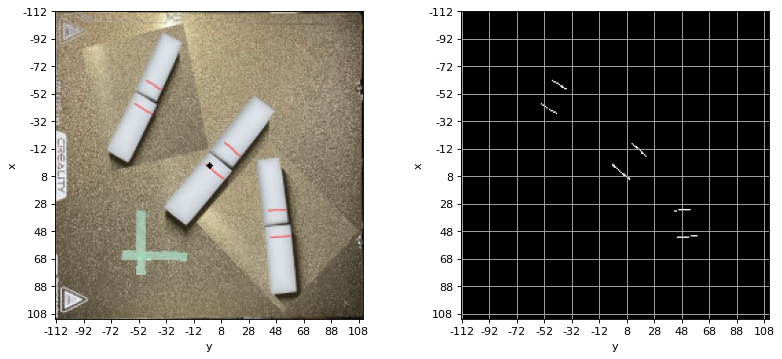

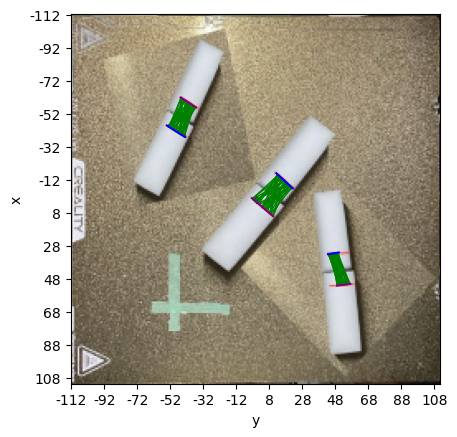

In [10]:
"""

  1. Cropping/Warping the image
  2. Creating masking image
  3. Clustering points into lines
  4. Pairing lines based on distance and parallelization

"""


cp = ConnectPoints(image_path=image_path, image_size=image_size, origin=origin)

# cp.crop_image(DOWN, UP, LEFT, RIGHT, display_or_not=False)
cp.warp_image(src_points=SRC, dst_points=DST)
cp.create_mask(red_th=RED, green_th=GREEN, blue_th=BLUE, color=MARKER_LINE_COLOR, display_or_not=True)

lines, kandb = cp.points_clustering(line_num=MARKER_LINE_NUM, random_state=MARKER_CLUSTERING_SEED, display_or_not=False)
line_pairs   = cp.pair_lines(lines, kandb)

print("\n\n")
pcds = []   # (line_pair, line, y, x)
for pair in line_pairs:
    pcd1, pcd2 = cp.connect_two_lines(lines[pair[0]], lines[pair[1]], color=SAMPLE_LINE_COLOR, sample_num=SAMPLE_LINE_NUM, random_seed=SAMPLE_SEED, display_or_not=True)
    pcds.append([pcd1, pcd2])

In [ ]:
# 1つ目のペアの中の2本目の線のｘとｙ座標の配列　[どのペア][何番目の線][y or x]
Ax = pcds[0][1][1] - origin[1]
Ay = pcds[0][1][0] - origin[0]

Ax, Ay

(array([-38.49494949, -44.01010101, -39.06060606, -42.66666667,
        -44.15151515, -44.43434343, -41.53535354, -39.41414141,
        -41.60606061, -44.08080808, -38.14141414, -44.50505051,
        -41.95959596, -42.87878788, -44.22222222, -40.54545455,
        -39.13131313, -40.33333333, -43.16161616, -39.76767677,
        -43.72727273, -39.55555556, -38.35353535, -40.12121212,
        -44.71717172, -40.61616162, -43.3030303 , -38.        ,
        -40.8989899 , -41.04040404, -42.45454545, -41.81818182]),
 array([-43.93013739, -52.62847121, -44.82227419, -50.5096463 ,
        -52.85150541, -53.29757381, -48.7253727 , -45.37985969,
        -48.8368898 , -52.73998831, -43.37255189, -53.40909091,
        -49.3944753 , -50.8441976 , -52.96302251, -47.16413329,
        -44.93379129, -46.82958199, -51.290266  , -45.93744519,
        -52.18240281, -45.60289389, -43.70710319, -46.49503069,
        -53.74364221, -47.27565039, -51.5133002 , -43.14951768,
        -47.7217188 , -47.944753  , -5

### **2. 線を引かない場合（現状黒の土台でのみ実行可能だが，精度はイマイチ）**

- 画像を手動でクロップ（自動にしたい場合はYoloとかの画像認識用の深層学習モデルを使用しましょう）

- 画像をリサイズ（緑線の間が 148px になる時の画像サイズは約 224px$\times$224px）

- 黒の土台でしたら運が良かったら行けるかもだが，精度は絶対上のよりは低いため，実験するときはマーカを使用した方がいいと思います．

In [ ]:
"""
board2+object:

DOWN: 985, UP: 170
LEFT: 320, RIGHT: 1165
"""


# Load the image
image = cv2.imread("/content/board1+object.png", cv2.IMREAD_GRAYSCALE)

# Function to crop the image
def crop_image(crop_down, crop_up, crop_left, crop_right, Ox, Oy):

    # Ensure the crop boundaries are valid
    cropped_image = image[crop_up:crop_down, crop_left:crop_right]
    resized_image = cv2.resize(cropped_image, (224, 224))
    cv2.circle(resized_image, center=(Ox, Oy), radius=3, color=(0, 0, 255), thickness=-1)

    # Display the cropped image
    plt.figure(figsize=(6, 6))
    plt.imshow(resized_image, cmap='gray')
    plt.axis('off')
    plt.show()



# Create interactive sliders for cropping parameters
interact(
    crop_image,
    crop_up=widgets.IntSlider(min=0, max=image.shape[0] - 1, step=1, value=105, description='Crop Up'),
    crop_down=widgets.IntSlider(min=1, max=image.shape[0], step=1, value=1000, description='Crop Down'),
    crop_left=widgets.IntSlider(min=0, max=image.shape[1] - 1, step=1, value=300, description='Crop Left'),
    crop_right=widgets.IntSlider(min=1, max=image.shape[1], step=1, value=1195, description='Crop Right'),
    Ox=widgets.IntSlider(min=115, max=120, step=1, value=112, description='Ox'),
    Oy=widgets.IntSlider(min=115, max=120, step=1, value=112, description='Oy'),
)


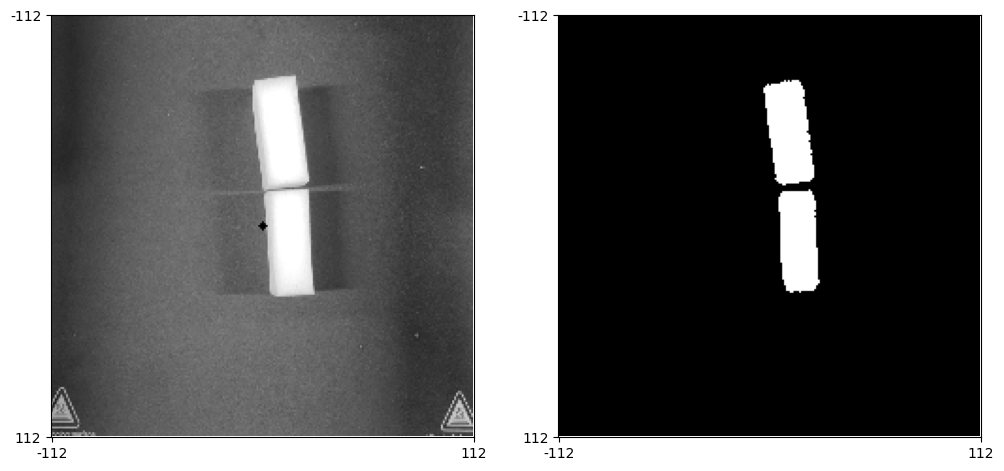

In [ ]:
DOWN, UP, LEFT, RIGHT, Ox, Oy = 985, 170, 320, 1165, 112, 112

# 画像の読み込み
image_path = '/content/board1+object.png'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)

cropped_image = image[UP:DOWN, LEFT:RIGHT]
resized_image = cv2.resize(cropped_image, (224, 224))
cv2.circle(resized_image, center=(Ox, Oy), radius=2, color=(0, 0, 0), thickness=-1)
binary_image = (resized_image>224).astype(np.int32)

plt.figure(figsize=(12, 6), dpi=100)

plt.subplot(1, 2, 1)
plt.imshow(resized_image, cmap='gray')
plt.xticks((0, 224), (-Ox, 224-Ox))
plt.yticks((0, 224), (-Oy, 224-Oy))

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.xticks((0, 224), (-Ox, 224-Ox))
plt.yticks((0, 224), (-Oy, 224-Oy))

plt.show()


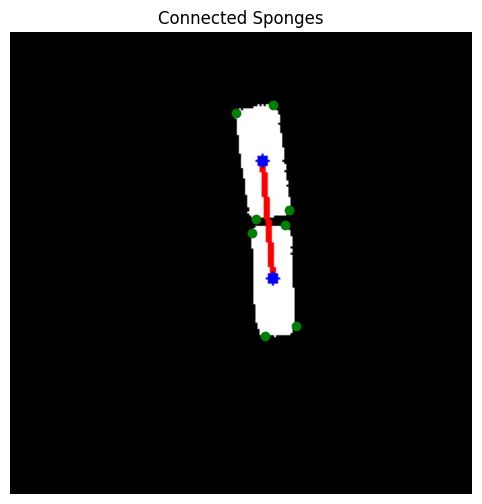

In [91]:
# Step 3: 輪郭検出 (各スポンジを検出)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: スポンジの重心を計算
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        # 重心の計算
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append((cx, cy))

# Step 5: スポンジ間を結ぶ (最も近いスポンジ間)
output_image = cv2.cvtColor(binary_image*255, cv2.COLOR_GRAY2BGR)
for i, center1 in enumerate(centroids):
    for j, center2 in enumerate(centroids):
        if i != j:
            # 距離の計算
            dist = np.linalg.norm(np.array(center1) - np.array(center2))
            if dist < 100:  # 隣接距離のしきい値 (適宜調整)
                cv2.line(output_image, center1, center2, (0, 0, 255), 2)  # 赤線で結ぶ

# Step 6: 重心点を描画 (確認用)
for center in centroids:
    cv2.circle(output_image, center, 3, (255, 0, 0), -1)  # 青い点で重心を描画

# 結果を表示
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
for contour in contours:
    epsilon = 0.05 * cv2.arcLength(contour, True)  # Approximation accuracy
    approx_corners = cv2.approxPolyDP(contour, epsilon, True)
    plt.scatter(approx_corners[:, 0, 0], approx_corners[:, 0, 1], color='green', label='Corners')

plt.title("Connected Sponges")
plt.axis("off")
plt.show()


In [ ]:
def sample_points_between(p1, p2, num_samples=5, scale=0.0):
    """
    Generate a numpy array of discrete sample points between two points in 2D space.

    Parameters:
        p1: Tuple (x1, y1) - The first point.
        p2: Tuple (x2, y2) - The second point.
        num_samples: int - Number of samples (including the start and end points).

    Returns:
        numpy.ndarray - An array of shape (num_samples, 2) with the sampled points.
    """
    p1 = np.array(p1)
    p2 = np.array(p2)

    grad = (p2 - p1) / np.linalg.norm(p2 - p1)
    p1 = p1 - scale * grad
    p2 = p2 + scale * grad

    return np.linspace(p1, p2, num_samples).astype(np.int32)


def draw_lines(pcd1, pcd2, color):
    """
    Draws lines connecting corresponding points from two point clouds (pcd1 and pcd2) on the same plot.

    Parameters:
        pcd1: List of points in the first point cloud (e.g., [(x1, y1), (x2, y2), ...])
        pcd2: List of points in the second point cloud (e.g., [(x1, y1), (x2, y2), ...])
        color: Color of the lines to be drawn.
    """
    # Iterate through both point clouds and connect corresponding points
    for point1, point2 in zip(pcd1, pcd2):
        x1, y1 = point1
        x2, y2 = point2
        plt.plot([x1, x2], [y1, y2], color=color, marker='o', markersize=4)

def is_opposite_side(line_point1, line_point2, test_point):
    """
    Check if two points (test_point1, test_point2) are on opposite sides of the line defined by line_point1 and line_point2.

    Parameters:
        line_point1: Tuple (x1, y1) defining the first point of the line
        line_point2: Tuple (x2, y2) defining the second point of the line
        test_point1: Tuple (x1, y1) defining the first test point
        test_point2: Tuple (x2, y2) defining the second test point

    Returns:
        True if the two test points are on opposite sides of the line, False otherwise
    """

    # Extract coordinates for easy access
    x1, y1 = line_point1
    x2, y2 = line_point2
    x3, y3 = test_point

    # Compute the direction of the line (normal vector to the line)
    # We use the cross product approach to check the position of points relative to the line
    def cross_product(x1, y1, x2, y2, x3, y3):
        return (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)

    # Cross product for both test points
    cp = cross_product(x1, y1, x2, y2, x3, y3)

    # If the cross products have opposite signs, the points are on opposite sides of the line
    return 1 if cp < 0 else -1

{'m00': 938.5, 'm10': 119438.33333333333, 'm01': 112542.0, 'm20': 15226238.583333332, 'm11': 14331767.291666666, 'm02': 13703249.25, 'm30': 1944361673.0, 'm21': 1828192468.55, 'm12': 1746140091.4166667, 'm03': 1693027907.9, 'mu20': 25902.44114426151, 'mu11': 9093.972540400922, 'mu02': 207562.76731486432, 'mu30': -658.5163538455963, 'mu21': -5379.604191749822, 'mu12': 13123.503471754491, 'mu03': -3669.0971217155457, 'nu20': 0.0294084504362588, 'nu11': 0.010324881706461411, 'nu02': 0.23565730044499, 'nu30': -2.440511578810873e-05, 'nu21': -0.0001993722136544437, 'nu12': 0.00048636699742298596, 'nu03': -0.00013597952362209685}
{'m00': 1043.5, 'm10': 127574.33333333333, 'm01': 65011.166666666664, 'm20': 15634175.083333332, 'm11': 7974964.041666666, 'm02': 4287247.916666666, 'm30': 1920521660.0, 'm21': 980611144.8333334, 'm12': 527521002.8333333, 'm03': 296667526.75, 'mu20': 37423.26211201586, 'mu11': 26946.555588830262, 'mu02': 236982.66380503587, 'mu30': -3456.3421745300293, 'mu21': -3459

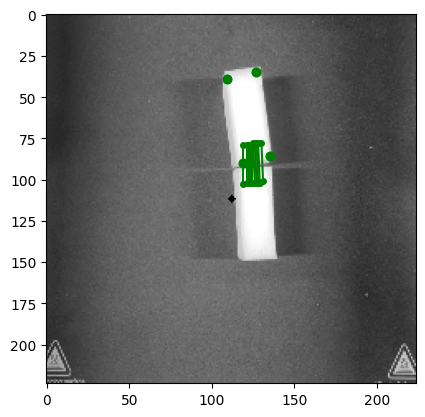

In [ ]:
from itertools import combinations

# Generate all combinations of two elements
num_pair = 2
contour_pairs = list(combinations(contours, num_pair))

# Convert tuples to lists if needed
result_as_lists = [list(pair) for pair in contour_pairs]

for contour_pair in contour_pairs:
    centroids = []
    target_corners = [[], []]     # target_corners: (contour, corner_x, corner_y)
    target_points  = [[], []]
    sample_points  = [[], []]

    for i in range(num_pair):
        M = cv2.moments(contour_pair[i])
        print(M)
        if M["m00"] != 0:
            # 重心の計算
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))

    for i in range(num_pair):
        epsilon = 0.05 * cv2.arcLength(contour_pair[i], True)  # Approximation accuracy
        approx_corners = cv2.approxPolyDP(contour_pair[i], epsilon, True)

        dists_plus, dists_minus = {}, {}
        for x, y in zip(approx_corners[:, 0, 0], approx_corners[:, 0, 1]):
            sign = is_opposite_side(centroids[0], centroids[1], (x, y))
            dist = sign * (np.linalg.norm(np.array((x, y)) - np.array(centroids[0])) + np.linalg.norm(np.array((x, y)) - np.array(centroids[1])))
            if sign == 1:
                dists_plus[(x, y)] = dist
            else:
                dists_minus[(x, y)] = dist

        dists_plus = {k: v for k, v in sorted(dists_plus.iで書いた線の本数（偶数を想定tems(), key=lambda item: item[1])}
        dists_minus = {k: v for k, v in sorted(dists_minus.items(), key=lambda item: item[1])}

        target_corners[i].append(list(dists_plus.keys())[0])
        target_corners[i].append(list(dists_minus.keys())[-1])

        target_points[i].append(sample_points_between(target_corners[i][0], centroids[i], num_samples=4)[1])
        target_points[i].append(sample_points_between(target_corners[i][1], centroids[i], num_samples=4)[1])

    sample_points[0] = [tuple(x) for x in sample_points_between(target_points[0][0], target_points[0][1], num_samples=10, scale=1)]
    sample_points[1] = [tuple(x) for x in sample_points_between(target_points[1][0], target_points[1][1], num_samples=10, scale=1)]

plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
draw_lines(sample_points[0], sample_points[1], "green")

for contour in contours:
    epsilon = 0.05 * cv2.arcLength(contour, True)  # Approximation accuracy
    approx_corners = cv2.approxPolyDP(contour, epsilon, True)
    # plt.scatter(approx_corners[:, 0, 0], approx_corners[:, 0, 1], color='green', label='Corners')

plt.show()

